---
title: "Ben & Jerry's | Hw 2 Post"
subtitle: "Building a linear regression model with PySpark and an ice cream dataset"
author: "Daniel Noone"
date: '2025-03-24'
categories: ['Homework', 'PySpark', 'Linear Regression']
image: ben.jpg
execute:
  warning: false
  message: false
toc: true
output:
  html_document:
    keep_md: true
---


In [4]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, when, log
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Loading the Data and Preparing for PySpark

In [31]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

ice_cream = pd.read_csv('https://bcdanl.github.io/data/ben-and-jerry-cleaned.csv')

def bool_to_int(df):
  for i in df.columns:
    if df[i].dtype == 'bool':
      df[i] = df[i].astype('int')
    else:
      pass
bool_to_int(ice_cream)

ice_cream = ice_cream[~ice_cream['tvcable'].isna()]

ice_cream.describe()


,priceper1,household_id,household_income,household_size,usecoup,couponper1,married,hispanic_origin,microwave,dishwasher,sfh,internet
count,21940.000000,2.194000e+04,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000
mean,3.314440,1.661833e+07,125226.982680,2.456746,0.106746,0.125500,0.604239,0.047995,0.981632,0.773063,0.731860,0.843163
std,0.665394,1.168728e+07,57120.924532,1.335610,0.308797,0.517386,0.489025,0.213760,0.134282,0.418861,0.443001,0.363655
min,0.000000,2.000358e+06,40000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,8.143519e+06,80000.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
50%,3.340000,8.401765e+06,110000.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,3.590000,3.018434e+07,170000.000000,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,9.480000,3.044069e+07,310000.000000,9.000000,1.000000,8.980000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
ice_cream = ice_cream[['household_income', 'household_size', 'couponper1', 'region', 'married', 'priceper1']]

vars_to_norm = ['household_income', 'household_size', 'couponper1']

def norm(df, cols):
  for i in cols:
    mean = df[i].mean()
    std = df[i].std()
    df[i] = (df[i] - mean) / std

norm(ice_cream, vars_to_norm)

<ipython-input-32-926c5e3bb6b1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = (df[i] - mean) / std


In [33]:
ice_cream.describe(include='all')

,household_income,household_size,couponper1,region,married,priceper1
count,2.194000e+04,2.194000e+04,2.194000e+04,21940,21940.000000,21940.000000
unique,NaN,NaN,NaN,4,NaN,NaN
top,NaN,NaN,NaN,South,NaN,NaN
freq,NaN,NaN,NaN,6706,NaN,NaN
mean,-7.643030e-17,-1.023389e-16,-4.793087e-17,NaN,0.604239,3.314440
std,1.000000e+00,1.000000e+00,1.000000e+00,NaN,0.489025,0.665394
min,-1.492045e+00,-1.090697e+00,-2.425653e-01,NaN,0.000000,0.000000
25%,-7.917761e-01,-3.419754e-01,-2.425653e-01,NaN,0.000000,3.000000
50%,-2.665745e-01,-3.419754e-01,-2.425653e-01,NaN,1.000000,3.340000
75%,7.838287e-01,4.067463e-01,-2.425653e-01,NaN,1.000000,3.590000


In [34]:
ic = spark.createDataFrame(ice_cream)
ic.show()

+--------------------+-------------------+-------------------+-------+-------+---------+
|    household_income|     household_size|         couponper1| region|married|priceper1|
+--------------------+-------------------+-------------------+-------+-------+---------+
| 0.08355987510778587|-0.3419754294514314|  0.723830630783873|Central|      0|     3.41|
| 0.08355987510778587|-0.3419754294514314|-0.2425653069622484|Central|      0|      3.5|
| 0.08355987510778587|-0.3419754294514314|-0.2425653069622484|Central|      0|      3.5|
| -0.9668432913541072|-1.0906972059372513|-0.2425653069622484|   West|      0|      3.0|
| 0.08355987510778587| 0.4067463470343886|-0.2425653069622484|  South|      1|     3.99|
| 0.08355987510778587| 0.4067463470343886|-0.2425653069622484|  South|      1|     3.89|
| 0.08355987510778587| 0.4067463470343886|-0.2425653069622484|  South|      1|     3.89|
|-0.26657451371284513|-1.0906972059372513|-0.2425653069622484|   East|      0|     2.14|
|  1.4840974303903098

# Model Overview

- The model will use **marital status, coupon amount per unit, region, household income, and household size.**

- coupon amount per unit, household income, and household size are all mean normalized

- marital status, and region will be one-hot encoded (marital status is single binary varible as it was boolean prior)

- The label data to be predicted is price per unit

# Data Transformation and Splitting

In [35]:
dtrain, dtest = ic.randomSplit([0.67, 0.33], seed = 123)

In [36]:
dtrain.describe().show()

+-------+--------------------+--------------------+--------------------+-------+-------------------+------------------+
|summary|    household_income|      household_size|          couponper1| region|            married|         priceper1|
+-------+--------------------+--------------------+--------------------+-------+-------------------+------------------+
|  count|               14653|               14653|               14653|  14653|              14653|             14653|
|   mean|0.001444483912653...|0.004972012187744043|3.222713433651515E-4|   NULL| 0.6045860915853409|3.3151769749735025|
| stddev|  1.0028801390568312|  1.0040586429435043|   1.010263935750957|   NULL|0.48895609764846787|0.6687969564086118|
|    min| -1.4920448745850536| -1.0906972059372513| -0.2425653069622484|Central|                  0|               0.0|
|    max|   3.234769374493465|   4.899077005949308|  17.113905734958088|   West|                  1|              9.48|
+-------+--------------------+----------

In [37]:
dtest.describe().show()

+-------+--------------------+--------------------+--------------------+-------+-------------------+------------------+
|summary|    household_income|      household_size|          couponper1| region|            married|         priceper1|
+-------+--------------------+--------------------+--------------------+-------+-------------------+------------------+
|  count|                7287|                7287|                7287|   7287|               7287|              7287|
|   mean|-0.00290462779913...|-0.00999792707381...|-6.48036502582157E-4|   NULL| 0.6035405516673528|  3.31295839949812|
| stddev|  0.9942455078562172|  0.9917815965837328|  0.9791034822325205|   NULL|0.48919545698711797|0.6585402074234148|
|    min| -1.4920448745850536| -1.0906972059372513| -0.2425653069622484|Central|                  0|               0.6|
|    max|   3.234769374493465|   4.899077005949308|   15.21976969697569|   West|                  1|               8.0|
+-------+--------------------+----------

In [38]:
def add_dummy_variables(var_name, reference_level, category_order=None):
    """
    Creates dummy variables for the specified column in the global DataFrames dtrain and dtest.
    Allows manual setting of category order.

    Parameters:
        var_name (str): The name of the categorical column (e.g., "borough_name").
        reference_level (int): Index of the category to be used as the reference (dummy omitted).
        category_order (list, optional): List of categories in the desired order. If None, categories are sorted.

    Returns:
        dummy_cols (list): List of dummy column names excluding the reference category.
        ref_category (str): The category chosen as the reference.
    """
    global dtrain, dtest

    # Get distinct categories from the training set.
    categories = dtrain.select(var_name).distinct().rdd.flatMap(lambda x: x).collect()

    # Convert booleans to strings if present.
    categories = [str(c) if isinstance(c, bool) else c for c in categories]

    # Use manual category order if provided; otherwise, sort categories.
    if category_order:
        # Ensure all categories are present in the user-defined order
        missing = set(categories) - set(category_order)
        if missing:
            raise ValueError(f"These categories are missing from your custom order: {missing}")
        categories = category_order
    else:
        categories = sorted(categories)

    # Validate reference_level
    if reference_level < 0 or reference_level >= len(categories):
        raise ValueError(f"reference_level must be between 0 and {len(categories) - 1}")

    # Define the reference category
    ref_category = categories[reference_level]
    print("Reference category (dummy omitted):", ref_category)

    # Create dummy variables for all categories
    for cat in categories:
        dummy_col_name = var_name + "_" + str(cat).replace(" ", "_")
        dtrain = dtrain.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))
        dtest = dtest.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))

    # List of dummy columns, excluding the reference category
    dummy_cols = [var_name + "_" + str(cat).replace(" ", "_") for cat in categories if cat != ref_category]

    return dummy_cols, ref_category


import numpy as np
import scipy.stats as stats
from tabulate import tabulate

def regression_table(model, assembler):
    """
    Creates a formatted regression table from a fitted LinearRegression model and its VectorAssembler,
    and inserts a dashed horizontal line after the Intercept row. The table includes separate columns
    for the 95% confidence interval lower and upper bounds for each coefficient (computed at the 5% significance level)
    and an "Observations" row (using model.summary.numInstances) above the R² row.
    The RMSE row is placed as the last row.

    The columns are ordered as:
        Metric | Value | Significance | Std. Error | p-value | 95% CI Lower | 95% CI Upper

    For the "Value", "Std. Error", "95% CI Lower", and "95% CI Upper" columns, commas are inserted every three digits,
    with 3 decimal places (except for Observations which is formatted as an integer with commas).

    Parameters:
        model: A fitted LinearRegression model (with a .summary attribute).
        assembler: The VectorAssembler used to assemble the features for the model.

    Returns:
        A formatted string containing the regression table.
    """
    # Extract coefficients and standard errors as NumPy arrays
    coeffs = model.coefficients.toArray()
    std_errors_all = np.array(model.summary.coefficientStandardErrors)

    # Check if the intercept's standard error is included (one extra element)
    if len(std_errors_all) == len(coeffs) + 1:
        intercept_se = std_errors_all[0]
        std_errors = std_errors_all[1:]
    else:
        intercept_se = None
        std_errors = std_errors_all

    # Compute t-statistics for feature coefficients (t = beta / SE(beta))
    # t_stats = coeffs / std_errors
    t_stats = model.summary.tValues

    # Degrees of freedom: number of instances minus number of predictors minus 1 (for intercept)
    df = model.summary.numInstances - len(coeffs) - 1

    # Compute the t-critical value for a 95% confidence interval (two-tailed, 5% significance)
    t_critical = stats.t.ppf(0.975, df)

    # Compute two-tailed p-values for each feature coefficient
    # p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stats]
    p_values = model.summary.pValues

    # Function to assign significance stars based on p-value
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build the table rows.
    # Order: Metric, Value, Significance, Std. Error, p-value, 95% CI Lower, 95% CI Upper.
    table = []
    for feature, beta, se, p in zip(assembler.getInputCols(), coeffs, std_errors, p_values):
        ci_lower = beta - t_critical * se
        ci_upper = beta + t_critical * se
        table.append([
            "Beta: " + feature,       # Metric name
            beta,                     # Beta estimate (Value)
            significance_stars(p),    # Significance stars
            se,                       # Standard error
            p,                        # p-value
            ci_lower,                 # 95% CI lower bound
            ci_upper                  # 95% CI upper bound
        ])

    # Compute and add the intercept row with its SE, p-value, significance, and CI (if available)
    if intercept_se is not None:
        intercept_t = model.intercept / intercept_se
        intercept_p = 2 * (1 - stats.t.cdf(np.abs(intercept_t), df))
        intercept_sig = significance_stars(intercept_p)
        ci_intercept_lower = model.intercept - t_critical * intercept_se
        ci_intercept_upper = model.intercept + t_critical * intercept_se
    else:
        intercept_se = ""
        intercept_p = ""
        intercept_sig = ""
        ci_intercept_lower = ""
        ci_intercept_upper = ""

    table.append([
        "Intercept",
        model.intercept,
        intercept_sig,
        intercept_se,
        intercept_p,
        ci_intercept_lower,
        ci_intercept_upper
    ])

    # Append overall model metrics:
    # Insert an Observations row using model.summary.numInstances,
    # then an R² row, and finally the RMSE row as the last row.
    table.append(["Observations", model.summary.numInstances, "", "", "", "", ""])
    table.append(["R²", model.summary.r2, "", "", "", "", ""])
    table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", ""])

    # Format the table.
    # For the "Value" (index 1), "Std. Error" (index 3), "95% CI Lower" (index 5), and "95% CI Upper" (index 6) columns,
    # format with commas and 3 decimal places, except for Observations which should be an integer with commas.
    # For the p-value (index 4), format to 3 decimal places.
    formatted_table = []
    for row in table:
        formatted_row = []
        for i, item in enumerate(row):
            if row[0] == "Observations" and i == 1 and isinstance(item, (int, float, np.floating)) and item != "":
                # Format Observations as integer with commas, no decimals.
                formatted_row.append(f"{int(item):,}")
            elif isinstance(item, (int, float, np.floating)) and item != "":
                if i in [1, 3, 5, 6]:
                    formatted_row.append(f"{item:,.3f}")
                elif i == 4:
                    formatted_row.append(f"{item:.3f}")
                else:
                    formatted_row.append(f"{item:.3f}")
            else:
                formatted_row.append(item)
        formatted_table.append(formatted_row)

    # Generate the table string using tabulate.
    table_str = tabulate(
        formatted_table,
        headers=["Metric", "Value", "Sig.", "Std. Error", "p-value", "95% CI Lower", "95% CI Upper"],
        tablefmt="pretty",
        colalign=("left", "right", "center", "right", "right", "right", "right")
    )

    # Insert a dashed line after the Intercept row for clarity.
    lines = table_str.split("\n")
    dash_line = '-' * len(lines[0])
    for i, line in enumerate(lines):
        if "Intercept" in line and not line.strip().startswith('+'):
            lines.insert(i+1, dash_line)
            break

    return "\n".join(lines)



In [39]:
region_dummys, region_reflev = add_dummy_variables('region', reference_level=0)
features = ['household_income', 'household_size', 'couponper1', 'married'] + region_dummys

Reference category (dummy omitted): Central


In [40]:
assembler = VectorAssembler(
    inputCols = features,
    outputCol='features')

dtrain1 = assembler.transform(dtrain)
dtest1  = assembler.transform(dtest)

model = LinearRegression(
    featuresCol='features',
    labelCol='priceper1'
).fit(dtrain1)

dtest1 = model.transform(dtest1)

print(regression_table(model, assembler))

+------------------------+--------+------+------------+---------+--------------+--------------+
| Metric                 |  Value | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+------------------------+--------+------+------------+---------+--------------+--------------+
| Beta: household_income | -0.060 | ***  |      0.006 |   0.000 |       -0.072 |       -0.048 |
| Beta: household_size   | -0.032 | ***  |      0.005 |   0.000 |       -0.043 |       -0.022 |
| Beta: couponper1       |  0.108 | ***  |      0.014 |   0.000 |        0.082 |        0.135 |
| Beta: married          | -0.076 | ***  |      0.016 |   0.000 |       -0.109 |       -0.044 |
| Beta: region_East      |  0.139 | ***  |      0.015 |   0.000 |        0.110 |        0.169 |
| Beta: region_South     | -0.018 |      |      0.016 |   0.243 |       -0.048 |        0.013 |
| Beta: region_West      |  0.048 | ***  |      0.014 |   0.002 |        0.020 |        0.076 |
| Intercept              |  3.325 | *** 

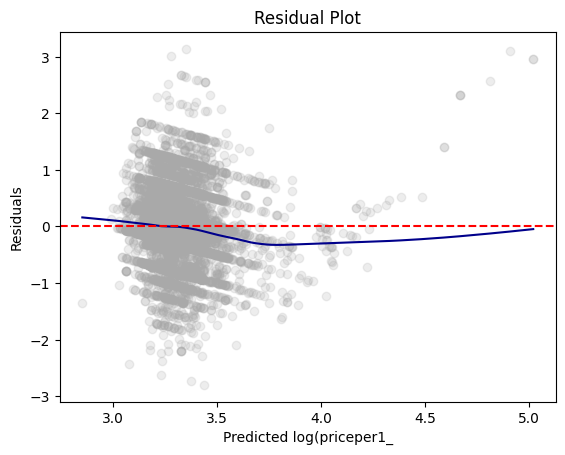

In [45]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

res = dtest1.select(["prediction", "priceper1"]).toPandas()
res['residual'] = res['priceper1'] - res['prediction']



plt.scatter(res["prediction"], res["residual"], alpha=0.2, color="darkgray")

smoothed = sm.nonparametric.lowess(res["residual"], res["prediction"])
plt.plot(smoothed[:, 0], smoothed[:, 1], color="darkblue")

plt.axhline(y=0, color="red", linestyle="--")

plt.xlabel("Predicted log(priceper1_")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


# Conclusion

> As is shown in both the R2 and Residual Plot, this model is not a very accurate one to use. More features and interactions would have to be tried to find a better perfomring model for this data.